In [49]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import scipy.optimize as optimization
import datetime

# Modern Portfolio Theory (Markowitz Model)

### Checking assumptions of Modern Portfolio Theory. 

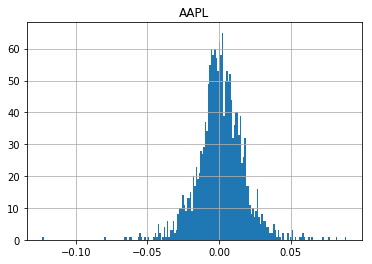

In [116]:
apple_stocks = ['AAPL']
apple_data = web.DataReader(apple_stocks, 
                            data_source='yahoo', 
                            start = '01/01/2010', 
                            end  = '01/01/2019')['Adj Close']
returns_1 = (apple_data/apple_data.shift(1))-1
returns_1.hist(bins = 200)
plt.show()

Assumptions:
* Returns are normally distributed.  
(returns are % increase in stock value from previous day)
* Investors take more risk if they are expecting more rewards!

### Downloading data from Yahoo Finance and plotting it.

In [232]:
stocks1 = ['AAPL','WMT', 'TSLA', 'GOOGL' ,'AMZN', 'TTM']
data = web.DataReader(stocks1, data_source = 'yahoo',
                      start ='01/01/2010',
                      end  = '01/01/2019')['Adj Close']
data.columns = stocks1

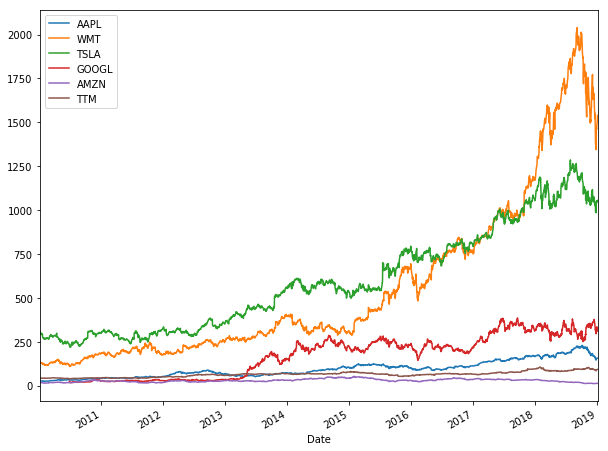

In [233]:
data.plot(figsize=(10,8))
plt.show()

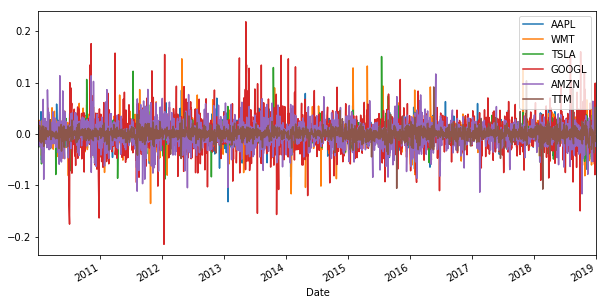

In [234]:
returns = np.log(data/data.shift(1))
returns.plot(figsize=(10,5))
plt.show()

* We can see here the average is approximately zero even if there are spikes up and down.

### Calculating the mean returns for each stock and the covariance matrix used to calculate the volatility.

In [251]:
print(returns.mean()*252)
print(returns.cov()*252)


AAPL     0.196592
WMT      0.271799
TSLA     0.134970
GOOGL    0.301588
AMZN    -0.037174
TTM      0.085838
dtype: float64
           AAPL       WMT      TSLA     GOOGL      AMZN       TTM
AAPL   0.066091  0.031276  0.028399  0.030857  0.031587  0.010369
WMT    0.031276  0.100114  0.042819  0.046577  0.036786  0.010918
TSLA   0.028399  0.042819  0.058923  0.033303  0.029306  0.010328
GOOGL  0.030857  0.046577  0.033303  0.264721  0.046077  0.012447
AMZN   0.031587  0.036786  0.029306  0.046077  0.142480  0.011922
TTM    0.010369  0.010918  0.010328  0.012447  0.011922  0.030757


### Randomly assigning initial proportion to each stock and calculating the return and volatility for that portfolio.

In [236]:
prop = np.random.random(len(stocks1))
prop = prop/np.sum(prop)
print(prop)

array([0.09842571, 0.29650819, 0.00461697, 0.21470504, 0.06282176,
       0.32292232])

In [237]:
pf_return = np.sum(returns.mean()*prop)*252
print(pf_return)

0.1906998394456936

In [238]:
pf_variance = np.sqrt(np.dot(prop.T,np.dot(returns.cov()*252,prop)))
print(pf_variance)

0.20663117119422666

### Using Monte - Carlo Algorithm to create 10,000 portfolios with different proportions.

In [239]:
pf_returns = []
pf_variances = []

for i in range(10000):
    prop1 = np.random.random(len(stocks1))
    prop1 = prop1/np.sum(prop1)
    pf_returns.append(np.sum(returns.mean()*prop1)*252)
    pf_variances.append(np.sqrt(np.dot(prop1.T,np.dot(returns.cov()*252,prop1))))
    

In [240]:
pf_returns = np.array(pf_returns)
pf_variances = np.array(pf_variances)
print(pf_returns[:5])
print(pf_variances[:5])

[0.15338601 0.14515854 0.20696868 0.16850676 0.19743185]
[0.22345238 0.19375727 0.21872433 0.20545283 0.2080433 ]


### Plotting return vs volatility for 10,000 portfolios and colouring it by the Sharpe ratio.

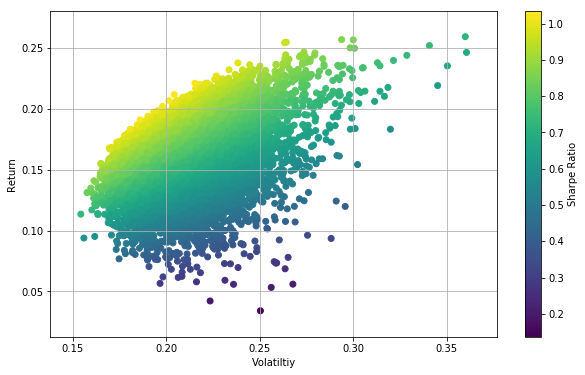

In [241]:
plt.figure(figsize=(10,6))
plt.scatter(pf_variances,pf_returns, c=pf_returns/pf_variances, marker = 'o')
plt.grid(True)
plt.xlabel('Volatiltiy')
plt.ylabel('Return')
plt.colorbar(label='Sharpe Ratio')
plt.show()

##### Sharpe ratio is ratio of return to risk and then we need to maximize it.

### Maximizing the Sharpe Ratio and obtaining optimum proportions

In [242]:
def construct(weights, returns):
    portf_returns = np.sum(returns.mean()*weights)*252
    portf_variances = np.sqrt(np.dot(weights.T,np.dot(returns.cov()*252,weights)))
    return np.array([portf_returns, portf_variances, portf_returns/portf_variances])

def parameter(weights, returns):
    return -construct(weights,returns)[2]

def optimize(weights,returns):
    con = ({'type':'eq','fun': lambda x: np.sum(x)-1})
    bo = tuple((0,1) for x in range(len(stocks1)))
    opt = optimization.minimize(fun = parameter, x0 = weights, args = returns, method = 'SLSQP', bounds = bo, constraints = con)
    return opt 

opt = optimize(prop, returns)

### Optimum Weights and Marking the portfolio with these optimum weights with the maximum Sharpe Ratio

In [243]:
eight_ops = np.array(weight_ops)
print(opt['x'].round(5))

array([0.30712, 0.33238, 0.     , 0.10587, 0.     , 0.25463])

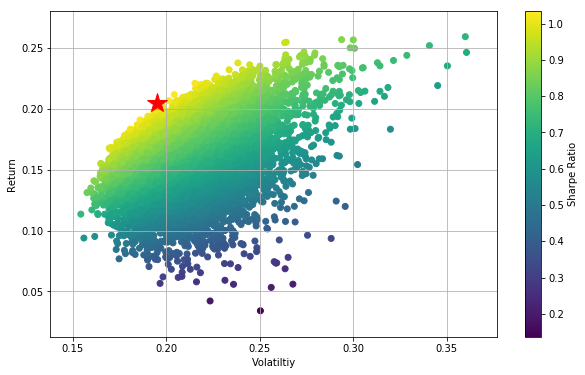

In [244]:
plt.figure(figsize=(10,6))
plt.scatter(pf_variances,pf_returns, c=pf_returns/pf_variances, marker = 'o')
plt.grid(True)
plt.xlabel('Volatiltiy')
plt.ylabel('Return')
plt.colorbar(label='Sharpe Ratio')
plt.plot(construct(opt['x'],returns)[1],construct(opt['x'],returns)[0],'r*', markersize = 20.0)
plt.show()

# Capital Asset Pricing Model

### Download stock data of Apple and market data S&P500

In [253]:
import pandas_datareader as pdr
risk_free_rate = 0.05

stock1 = pdr.get_data_yahoo('AAPL', '01/01/2010', '01/01/2019')
stock2 = pdr.get_data_yahoo('^GSPC', '01/01/2010', '01/01/2019')


return_stock1 = stock1.resample('M').last()
return_stock2 = stock2.resample('M').last()

Here we have takem risk free rate as 0.05

### Calculating the return for market and stock data: (monthly return)

In [246]:
data1 = pd.DataFrame({'s_adjclose': return_stock1['Adj Close'], 'm_adjclose': return_stock2['Adj Close']}, index = return_stock1.index)
data1[['s_returns','m_returns']] = np.log(data1[['s_adjclose','m_adjclose']]/data1[['s_adjclose','m_adjclose']].shift(1))
data1 = data1.dropna()

### Calculating $\beta$ using formula and linear regression.

In [247]:
covmat = np.cov(data1['s_returns'], data1['m_returns'])
beta = covmat[0,1]/covmat[1,1]
print(beta)

0.9570649684008123


In [248]:
beta, alpha = np.polyfit(data1['m_returns'], data1['s_returns'], deg=1)
print(beta)

0.9570649684008121


### Plotting stock return vs market return and regression line 

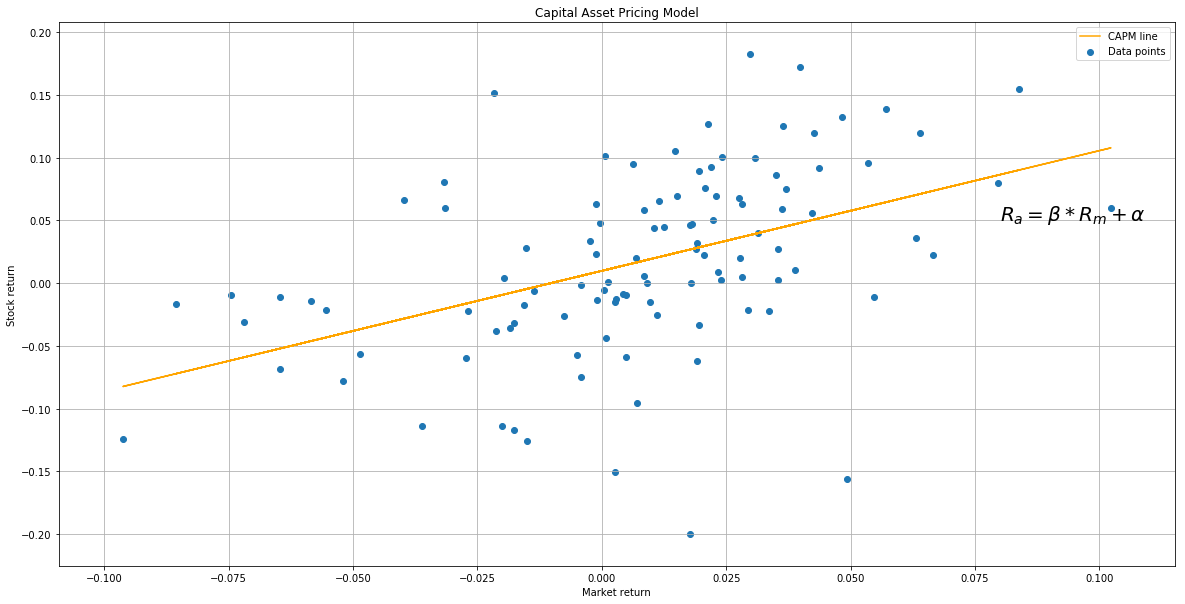

In [249]:
fig,axis = plt.subplots(1,figsize = (20,10))
axis.scatter(data1['m_returns'], data1['s_returns'], label = 'Data points')
axis.plot(data1['m_returns'], beta*data1['m_returns'] + alpha, color = 'orange', label = 'CAPM line')
plt.title('Capital Asset Pricing Model')
plt.xlabel('Market return')
plt.ylabel('Stock return')
plt.text(0.08,0.05, r'$R_a = \beta * R_m + \alpha$', fontsize = 20)
plt.legend()
plt.grid(True)
plt.show()

### Calculating expected return

In [254]:
expected_return = risk_free_rate + beta*(data1["m_returns"].mean()*12 - risk_free_rate)
print(expected_return)

0.09243262125225102


Therefore this is actually a good return because since our risk free rate is 0.05 and we are getting an expected return of 0.09. So the market premium is 0.04. 